## compare different word embeddings

In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [15]:
import pickle
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("data/all_sales.csv", encoding='latin-1')
print(df.shape)

(28626, 10)


In [4]:
df.head(3)

,Unnamed: 0,Address,Apt,bedroom,bathroom,size,intro,photo,price,price(k)
0,3,1 5th Avenue,9B,2.0,2.0,1150.0,Please call to schedule a private viewing Buil...,['https://d2787ndpv5cwhz.cloudfront.net/453a7f...,2850000,2850.0
1,6,1 Bay Club Dr,11D,2.0,2.0,1400.0,Renovated Large 2 Bedroom 2 Bathroom. Nice Wat...,['http://photos.v3.mlsstratus.com/Live/photos/...,938000,938.0
2,8,1 Bay Club Dr,16-A,2.0,2.0,1250.0,Stunning Hi Floor 2 Bedroom-2 Baths Filled Wit...,['http://photos.v3.mlsstratus.com/Live/photos/...,899000,899.0


## load pre-train model

[GloVe](https://nlp.stanford.edu/projects/glove/) Global Vectors for Word Representation (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors)


[Gensim](https://code.google.com/archive/p/word2vec/) Pre-trained word and phrase vectors (300-dimensional vectors for 3 million words and phrases)

#### GloVe

In [ ]:
# convert txt to dictionary and save in pickle for further use

word2ebedding = {}

with open(f'data/glove.6B/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        vect = np.array(line[1:]).astype(np.float)
        word2ebedding[word] = vect

with open('data/glove50.pickle', 'wb') as handle:
    pickle.dump(word2ebedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

# repeat this process for GloVe 100/200/300d

In [5]:
glove50 = pickle.load(open(f'data/glove50.pickle', 'rb'))

In [64]:
# glove50 = pickle.load(open(f'data/glove50.pickle', 'rb'))
glove100 = pickle.load(open(f'data/glove100.pickle', 'rb'))
glove200 = pickle.load(open(f'data/glove200.pickle', 'rb'))
glove300 = pickle.load(open(f'data/glove300.pickle', 'rb'))

#### gensim

In [147]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
gensim300 = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## train customer words embedding

In [ ]:
corpus = df["intro"].values
# we need to pass splitted sentences to the model
tokenized_sentences = [sentence.split() for sentence in corpus if type(sentence)==str and len(sentence)>3]

In [ ]:
# train model
model20 = Word2Vec(tokenized_sentences, 
                 min_count=3,   # Ignore words that appear less than this
                 size=20,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5)      # Context window for words during training

In [ ]:
model20.save('data/model20.bin')

In [149]:
model20 = Word2Vec.load('data/model20.bin')

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# word_vector

In [65]:
def parse(df, embedding, number):
    word_vector = np.zeros((number,))
    for intro in df["intro"].values:
        if type(intro)==str:
            token = intro.split()
            s = np.zeros((number,))
            for i in token:
                i = i.lower()
                try:
                    s = s + embedding[i]
                except:
                    s = s
            word_vector = np.vstack([word_vector, s])
        else:
            word_vector = np.vstack([word_vector, np.zeros((number,))])
    word_vector = word_vector[1:]
    sdf = pd.DataFrame(word_vector)
    df1 = pd.concat([df, sdf], axis=1)
    df1 = df1[~df1["price(k)"].isna()]
    return df1

In [145]:
df_glove50 = parse(df, glove50, 50)
df_glove100 = parse(df, glove100, 100)
df_glove200 = parse(df, glove200, 200)
df_glove300 = parse(df, glove300, 300)

In [148]:
df_gensim300 = parse(df, gensim300, 300)

In [150]:
df_self_train20 = parse(df, model20, 20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


## train and test

In [51]:
def inputdata(df_name, n):
    df_name = df_name[~df_name["price(k)"].isna()]
    df = df_name.sample(frac=1)
    vars_housing   = ['bedroom', 'bathroom', 'size'] + list(range(n))
    target_housing = ["price(k)"]
    X = df[vars_housing ] 
    y = df[target_housing ]
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    xscale=scaler_x.fit_transform(X)
    yscale=scaler_y.fit_transform(y)
    return xscale, yscale

In [77]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
def build_model(x):
    model = Sequential()
    model.add(Dense(32, kernel_initializer='normal', activation=tf.nn.relu, input_shape=[x.shape[1]]))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1, kernel_initializer='normal'))
#     optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mean_squared_error',
                optimizer="adam",
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

## glove 50

In [100]:
x, y = inputdata(df_glove50, 50)
model = build_model(x)
model.summary()
history_glove50 = model.fit(x, y, epochs=150, verbose=0, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                1728      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


## glove 100

In [70]:
x, y = inputdata(df_glove100, 100)
model = build_model(x)
model.summary()
history_glove100 = model.fit(x, y, epochs=150, verbose=0, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                3328      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


## glove 200

In [80]:
x, y = inputdata(df_glove200, 200)
model = build_model(x)
model.summary()
history_glove200 = model.fit(x, y, epochs=150, verbose=0, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                6528      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
_________________________________________________________________


## glove 300

In [90]:
x, y = inputdata(df_glove300, 300)
model = build_model(x)
model.summary()
history_glove300 = model.fit(x, y, epochs=150, verbose=0, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                9728      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 9,761
Trainable params: 9,761
Non-trainable params: 0
_________________________________________________________________


## gensim 300

In [151]:
x, y = inputdata(df_gensim300, 300)
model = build_model(x)
model.summary()
history_gensim300 = model.fit(x, y, epochs=150, verbose=0, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                9728      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 9,761
Trainable params: 9,761
Non-trainable params: 0
_________________________________________________________________


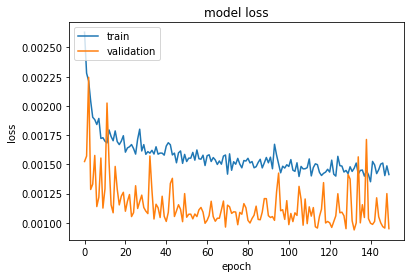

In [153]:
# "Loss"
plt.plot(history_gensim300.history['loss'])
plt.plot(history_gensim300.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## self train

In [154]:
x, y = inputdata(df_self_train20, 20)
model = build_model(x)
model.summary()
history_self_train20 = model.fit(x, y, epochs=150, verbose=0, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                768       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


## train loss & validation loss

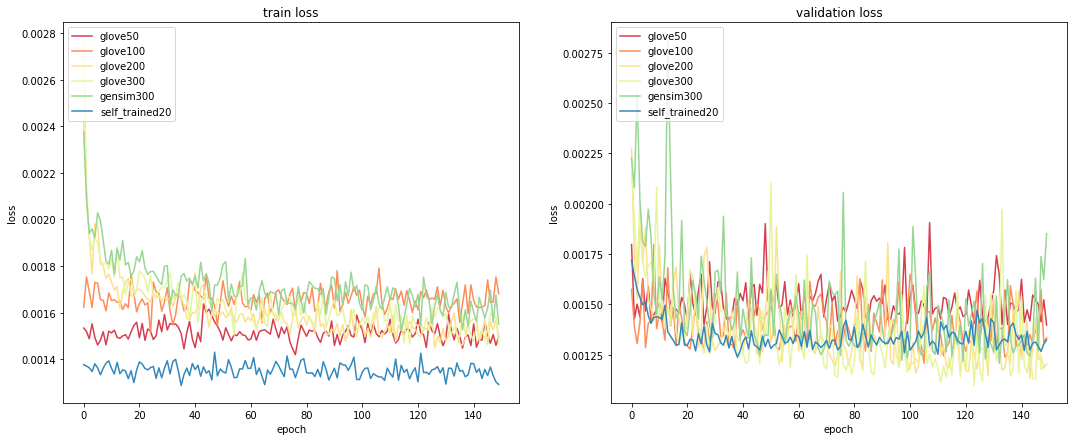

In [144]:
# "Loss"
plt.figure(figsize=(18,7))
plt.subplot(121)
plt.plot(history_glove502.history['loss'], color='#d53e4f', linestyle="-")
plt.plot(history_glove1001.history['loss'], color='#fc8d59', linestyle="-")
plt.plot(history_glove2001.history['loss'], color='#fee08b', linestyle="-")
plt.plot(history_glove3001.history['loss'], color='#e6f598', linestyle="-")
plt.plot(history_gensim300.history['loss'], color='#99d594', linestyle="-")
plt.plot(history_self_train20.history['loss'], color='#3288bd', linestyle="-")
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['glove50', 'glove100', 'glove200', 'glove300', 'gensim300', 'self_trained20'], loc='upper left')
plt.subplot(122)
plt.plot(history_glove502.history['val_loss'], color='#d53e4f', linestyle="-")
plt.plot(history_glove1001.history['val_loss'], color='#fc8d59', linestyle="-")
plt.plot(history_glove2001.history['val_loss'], color='#fee08b', linestyle="-")
plt.plot(history_glove3001.history['val_loss'], color='#e6f598', linestyle="-")
plt.plot(history_gensim300.history['val_loss'], color='#99d594', linestyle="-")
plt.plot(history_self_train20.history['val_loss'], color='#3288bd', linestyle="-")
plt.title('validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['glove50', 'glove100', 'glove200', 'glove300', 'gensim300', 'self_trained20'], loc='upper left')
plt.show()
